---
title: "Gauss and Groebner Egraphs: Intrinsic Linear and Polynomial Equations"
date: 2024-07-15
---

It is a paradoxical bummer that associativity and commutativity are two hard to orient rules (the point of the egraph approach) but also highly explosive for what feels like administrative manipulations.

In particular, associativity and commutativity are properties of multiplication and addition of familiar ordinary numbers. 

Linear and polynomials expressions have pretty good special methods for them. Using general term rewriting or egraph techniques to solve linear equations feels like insanity. 

Humanity is so good at linear equations. It's kind of one of the few mathematical things we can do at scale. So, is there an intrinsic way of bolting linear equality and polynomial equality reasoning into egraph equality saturation?

Yeah, I think so.

In short, replace the union find by reduced row echelon form / groebner basis and use bottom up e-matching.

## What are Union Finds?
Union finds "solve" equations of the form `x0 = x1, x1 = x2, x1 = x2, x3 = x4`

A union find is a forest of equivalence classes. Each tree in the forest is one equivalence class. The children point up to the parents for a fast `find` operation to get a canonical member (the root) of each eq class.

This might result in a union find that looks like

`x0 -> x2`

`x1 -> x2`

`x3 -> x4`

![union find](/assets/uf.svg)

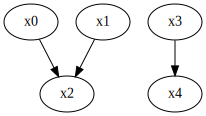

In [31]:
from graphviz import Digraph


dot = Digraph()

uf = [("x0", "x2"), ("x1", "x2"), ("x3", "x4")]
for edge in uf:
    dot.edge(edge[0], edge[1])
dot

## Linear Algebra and Unions Finds
These equations can also be interpreted as a linear equations though.

We can rewrite the simple equations `x0 = x2` as `x0 - x2 = 0`. This can be seen as dot product `(1 0 -1 ...) . (x0 x1 x2 ...) = 0`

When we have multiple equations, these each become a row in a constraint matrix `Ax = 0`.

For example, the equations `x0 = x1, x1 = x2, x1 = x2, x3 = x4` becomes the rows of the matrix R

In [3]:
import sympy as sp
A =   sp.Matrix([
    [1,-1, 0,0, 0],  # x0 = x1
    [0, 1,-1,0, 0],  # x1 = x2
    [0, 1, -1, 0,0], # x1 = x2
    [0, 0, 0,1,-1],  # x3 = x4
   # [0, 1, 0,0,-1],
    ])
sp.pprint(A)


⎡1  -1  0   0  0 ⎤
⎢                ⎥
⎢0  1   -1  0  0 ⎥
⎢                ⎥
⎢0  1   -1  0  0 ⎥
⎢                ⎥
⎣0  0   0   1  -1⎦


We can get the reduced row echelon form. This is using row additions turn turn the leading coefficients to 1 and clear out that coefficient from the lower rows.
https://en.wikipedia.org/wiki/Row_echelon_form

In [4]:
# reduced row echelon form
sp.pprint(A.rref()[0])

⎡1  0  -1  0  0 ⎤
⎢               ⎥
⎢0  1  -1  0  0 ⎥
⎢               ⎥
⎢0  0  0   1  -1⎥
⎢               ⎥
⎣0  0  0   0  0 ⎦


 The row echelon form gives us a notion of normalizing a linear expression.

Each nonzero row of this matrix can be interpreted as a normalizing rewrite system.
`x0 -> x2`
`x1 -> x2`
`x3 -> x4`

Such a rewrite system can also be seen as a forest of equivalence classes, aka the union find. The rhs are the roots of the tree and the lhs are the children of the roots.

Any linear expression we write down can be put into a canonical form by running these rules. I'm not exactly sure how to express this elegantly in linear algebraic language, but it is obviously imperatively doable. Take your input vector, go down each row and use it to replace that column. This is similar to inverting? Let's just move on to groebner bases where it's more obvious.

As an alternative motivation for the connection between union finds and linear algebra, note that union finds are useful for finding connected components in a graph. Adjacency matrices are also an encoding of the graph and connected component (or interestingly approximate connected component) information can be extracted via linear algebraic or spectral means. So there is similar junk in there.

## Gaussian Elimination and Groebner Bases
It turns out that it will be easiest to immediately use the generalization of these considerations, [Groebner bases](https://en.wikipedia.org/wiki/Gr%C3%B6bner_basis). This is a good tutorial https://mattpap.github.io/masters-thesis/html/src/groebner.html

Groebner bases are a canonical form for a set of multinomial equations with good behavior with respect to polynomial division. 

This directly generalizes the reduced row echelon form above. The grobner basis for linear polynomials `x0 - x1 = 0` etc will be in exactly the same form as the reduced row echelon form.

In [13]:
import sympy as sp
xs = sp.symbols('x0 x1 x2 x3 x4')
x0, x1, x2, x3, x4 = xs
eqs = [
    x0 - x1,
    x1 - x2,
    x1 - x2,
    x3 - x4,
]
G = sp.groebner(eqs, xs, order='lex')
G

GroebnerBasis([x0 - x2, x1 - x2, x3 - x4], x0, x1, x2, x3, x4, domain='ZZ', order='lex')

When we have a grobner basis in hand, we can reduced a polynomial expression to a canonical form via a process of multinomial division. `sympy` implements this is [`sympy.redcued`](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.polytools.reduced)

Here we see `x0` reduces to the canonical `x2`, the same as the above union find.

In [19]:
# The first is coefficients of the grobner basis, the second is the remainder aka canonical terms
sp.reduced(x0, G) 

([1, 0, 0], x2)

More examples of canonical forms coming from this system

In [25]:
print(f"{sp.reduced(x0, G)=}")
print(f"{sp.reduced(x1, G)=}")
print(f"{sp.reduced(x2, G)=}")
print(f"{sp.reduced(x3, G)=}")
print(f"{sp.reduced(x4, G)=}")
print(f"{sp.reduced(x0+2*x2 + 17*x3, G)=}")
print(f"{sp.reduced(3*x0 + 25*x4 - 8*x3, G)=}") # another way of writing same linear combination under these assumptions

sp.reduced(x0, G)=([1, 0, 0], x2)
sp.reduced(x1, G)=([0, 1, 0], x2)
sp.reduced(x2, G)=([0, 0, 0], x2)
sp.reduced(x3, G)=([0, 0, 1], x4)
sp.reduced(x4, G)=([0, 0, 0], x4)
sp.reduced(x0+2*x2 + 17*x3, G)=([1, 0, 17], 3*x2 + 17*x4)
sp.reduced(3*x0 + 25*x4 - 8*x3, G)=([3, 0, -8], 3*x2 + 17*x4)


# Egraphing it

Ok, an egraph is basically some kind of node table associating eclasses to enodes + a union find.

We will use sympy symbols `ei` to rerpesent our eclasses and the stock sympy groebner basis routines to do the union find action. The point of the union find is you can add new equalities and you can normalize an eclass by calling find.

| union find | groebner |
|------------|----------|
| union      | add eq   |
| find       | reduce   |


Curiously and interestingly now, you can multiply and add eclasses.


In [127]:
from dataclasses import dataclass
EClass = sp.Symbol
ENode = tuple[str,...]
# helper functions to turn integers into sympy symbols
def sympy_eclass(n):
    return sp.symbols('e' + str(n))
def eclass_of_sympy(eclass):
    return int(eclass.name[1:])

@dataclass
class EGraph:
    poly_eqs : list[sp.Expr]
    hashcons : dict[ENode, EClass]
    eclasses : list[EClass]
    
    def __init__(self):
        self.poly_eqs = []
        self.hashcons : Dict[ENode, EClass] = {}
        self.eclasses = []
    def find(self, x : EClass) -> EClass:
        return sp.reduced(x, self.poly_eqs, self.eclasses)[1]
    def union(self, x : EClass,y : EClass) -> EClass:
        x = self.find(x)
        y = self.find(y)
        if x != y:
            self.poly_eqs.append(x - y)
    def makeset(self):
        x = sympy_eclass(len(self.eclasses))
        self.eclasses.append(x)
        return x
    def make(self, t : ENode) -> EClass:
        t1 = self.hashcons.get(t)
        if t1 == None:
            v = self.makeset()
            self.hashcons[t] = v
            return v
        else:
            return t1
    def rebuild(self):
        # simple naive dumb rebuild step. Could be optimized signifcantly
        while True:
            #rebuild "union find"
            self.poly_eqs = list(sp.groebner(self.poly_eqs, *self.eclasses))

            # rebuild hashcons"
            newhashcons = {}
            for k,v in self.hashcons.items():
                (f,*args) = k
                args = map(self.find,args) # normalize argument eclasses
                enode = (f,*args)
                eclass = self.hashcons.get(enode)
                if eclass != None:
                    self.union(v,eclass)
                newhashcons[enode] = self.find(v)
            if self.hashcons == newhashcons:
                return
            self.hashcons = newhashcons   
    def add_term(self, t):
        if isinstance(t, sp.Expr): # allow partial terms that contain eclasses
            return t
        f, *args = t
        args = map(self.add_term,args)
        return self.make_enode((f,*args))
    def check_term(self, t):
        if isinstance(t, sp.Expr): # allow partial terms that contain eclasses
            return t
        f, *args = t
        map(self.check_term,args)
        return (f,*args)
    def make_enode(self, enode):
        eclass = self.hashcons.get(enode)
        if eclass == None:
            eclass = self.makeset() 
            self.hashcons[enode] = eclass
        return eclass


Fooling around a little with a toy egraph example. We can do algebra on eclasses because they are sympy variables. Here I assert $bar^2 = foo(bar)$

In [128]:
E = EGraph()
foobar = E.add_term(("foo", ("foo", ("bar",))))
bar = E.add_term(("bar",))
print(E)
E.union(foobar, bar)
E.rebuild()
print(E)
E.union(bar*bar, foobar)
E.rebuild()
print(E)


EGraph(poly_eqs=[], hashcons={('bar',): e0, ('foo', e0): e1, ('foo', e1): e2}, eclasses=[e0, e1, e2])
EGraph(poly_eqs=[e0 - e2], hashcons={('bar',): e2, ('foo', e2): e1, ('foo', e1): e2}, eclasses=[e0, e1, e2])
EGraph(poly_eqs=[e0 - e2, e2**2 - e2], hashcons={('bar',): e2, ('foo', e2): e1, ('foo', e1): e2}, eclasses=[e0, e1, e2])


Here's an example asserting $\sin(bar)^2 + \cos(bar)^2 = 1$ and $bar = biz$, which simplifies $\sin(bar)^2 + \cos(biz)^2$

In [133]:
E = EGraph()
sinbar = E.add_term(("sin", ("bar",)))
cosbiz = E.add_term(("cos", ("biz",)))
cosbar = E.add_term(("cos", ("bar",)))
t1 = E.add_term(sinbar*sinbar + cosbiz*cosbiz)
t2 = E.add_term(sinbar*sinbar + cosbar*cosbar)
print(E)
print(f"sin(bar)**2 + cos(bar)**2 == {t2}")
E.union(t2, 1)
E.rebuild()
print(E)
bar = E.add_term(("bar",))
biz = E.add_term(("biz",))
E.union(biz,bar)
E.rebuild()
print(E)

EGraph(poly_eqs=[], hashcons={('bar',): e0, ('sin', e0): e1, ('biz',): e2, ('cos', e2): e3, ('cos', e0): e4}, eclasses=[e0, e1, e2, e3, e4])
sin(bar)**2 + cos(bar)**2 == e1**2 + e4**2
EGraph(poly_eqs=[e1**2 + e4**2 - 1], hashcons={('bar',): e0, ('sin', e0): e1, ('biz',): e2, ('cos', e2): e3, ('cos', e0): e4}, eclasses=[e0, e1, e2, e3, e4])
EGraph(poly_eqs=[e0 - e2, e1**2 + e4**2 - 1, e3 - e4], hashcons={('bar',): e2, ('sin', e2): e1, ('biz',): e2, ('cos', e2): e4}, eclasses=[e0, e1, e2, e3, e4])


## Bottom Up E-matching

Again, I think bottom up ematching is the way to go when you need to integrate theories into egraph rewriting. Bottom up e-matching guesses what goes into the pattern variables. You can maintain some explicit set of variable guess terms (every term you've explicitly mentioned previously) or similarly just throw in all the eclasses. Then you can normalize them with respect to the egraph and permit the rule to fire if the lhs falls in some heuristic set. The set is commonly the set of terms held in the egraph. Here I just always allow the rule to fire. This is probably more eager than you'd like.

Which linear combinations you should initiate the variables with is not obvious and there is an infinite number of choices. At least naively speaking, it seems you're screwed in terms of completeness. E-graph rewriting was never complete. This is pragmatic mix of what seems readily at hand and doable. Completeness is overrated, but also it feels like complete methods are the only ones that survive, since everyone has their own preferred heuristics. Me dunno.

In [85]:
import itertools
def rw(self, n, f):
    for eclasses in itertools.product(self.eclasses, repeat=n):
        lhs, rhs = f(*eclasses)
        # whatever
        lhs = self.add_term(lhs)
        rhs = self.add_term(rhs)
        self.union(lhs, rhs)
EGraph.rw = rw

In [89]:
E = EGraph()
foobar = E.add_term(("foo", ("foo", ("bar",))))
print(E)
#E.rw(1, lambda x: (("foo", x), x))
E.rw(1, lambda x: (("foo", x), 2*x))
#E.rw(1, lambda x: (("foo", 2*x), x))
print(E)
E.rebuild()
E

EGraph(poly_eqs=[], hashcons={('bar',): e0, ('foo', e0): e1, ('foo', e1): e2}, eclasses=[e0, e1, e2])
EGraph(poly_eqs=[-2*e0 + e1, -2*e1 + e2, -2*e2 + e3], hashcons={('bar',): e0, ('foo', e0): e1, ('foo', e1): e2, ('foo', e2): e3}, eclasses=[e0, e1, e2, e3])


EGraph(poly_eqs=[8*e0 - e3, 4*e1 - e3, 2*e2 - e3], hashcons={('bar',): e3/8, ('foo', e3/8): e3/4, ('foo', e3/4): e3/2, ('foo', e3/2): e3}, eclasses=[e0, e1, e2, e3])

# Bits and Bobbles

Fully normalizing the to the grobner basis may be overkill. It tends to be a property of egraphs that they are self healing in the face of incomplete canonicalization / hash consing. They can recover later. https://en.wikipedia.org/wiki/Wu%27s_method_of_characteristic_set My impression of Wu's method is that it very successful but slightly more ad hoc method for doing geoemtric theorem proving while still using the same basic idea of polynomial division that grobner bases do.

lex monomial ordering is typically not the best performing one to my understanding. It is the easiest to interpret though. I think other orders ought to work fine.

There was this idea of "symbolic" lattices in egglog. If we defined a lattice using egraph equations for join the "merge" annotation for the table could refer to this insitead of to a primitive lattice like i64-min.

Semiring semantics. Is this getting close to an interesting intertwined notion of semiring semantics? Instead of an a priori quotient ring we could discover what ring we're in and normalize all truth valuers via the grobner. Hmm.

A represntation that is "off by 1" from the above is polynomials as just another kind of container. Containers have a theory specific notion of rebuilding. Sets for example deduplicate and sort on rebuilding (they may have discovered new equations, so sets could shrink). Polynomials are just another container for eclasses. Enodes are just an ordered fixed size array container. https://www.philipzucker.com/bottom_up/

"Proof producing" row echelon form is working with the augmented matrix (stacking on an identity matrix) https://en.wikipedia.org/wiki/Augmented_matrix. `E * [R | I] = [E*R | E] = S`. There was something similar you can do for groebner bases I mentioned here. https://www.philipzucker.com/computing-syzygy-modules-in-sympy/ extra variables to track how you derived the grobner basis from your original equations. One new variable per equation `f`. I barely understand what I'm talking about here. A lesson for the future to write better? Or just evidence my mind changes.

I basically never implement extraction. Does anything fishy happen? I don't think so.

maybe there is a way to bootstrap off of the sympy simplify rules like I could off of z3's. I'm not actually sure I have to opaquify to sympy in the from of the `ei`. Maybe sympy is happy doing groebner bases over compound terms? Then I could take the GRS strategy. This is the analog of what I did for z3 here https://www.philipzucker.com/ext_z3_egraph/
I have noticed in the past it is quite hard to stop sympy from doing simplification when you construct terms. `evaluate=False` didn't seem like a panacea


In [110]:
# yeah, seems like I didn't need the node table. I could just use sympy terms.
# but ultimately I want to also bolt in other stuff?
foo = sp.Function("foo")
bar = sp.Function("bar")
biz = sp.Function("biz")
eq = [foo(bar()) - bar()]
print(sp.reduced(foo(bar()), eq))
print(sp.reduced(bar(), eq))
e1,e2 = sp.symbols("e1 e2")
eq = [e1 - e2, foo(e1) - e2, bar() - e1]
print(sp.reduced(e2, eq))

print(sp.groebner(eq)) #nice

# ok but it doesn't do inner stuff, so we shouyld traverse manually.
print(sp.reduced(foo(biz()), [bar() - biz()]))
print(sp.reduced(foo(bar()), [bar() - biz()]))



([0], foo(bar()))
([-1], foo(bar()))
([0, -1, 0], foo(e1))
GroebnerBasis([e1 - foo(e1), e2 - foo(e1), bar() - foo(e1)], e1, e2, bar(), foo(e1), domain='ZZ', order='lex')
([0], foo(biz()))
([0], foo(bar()))


In [112]:
def rec_reduced(t, eqs):
    args = map(lambda arg: rec_reduced(arg,eqs), t.args)
    return sp.reduced(t.func(*args), eqs)[1]
print(rec_reduced(foo(bar()), [bar() - biz()]))
print(rec_reduced(foo(biz()), [bar() - biz()]))

# https://www.philipzucker.com/ext_z3_egraph/
class EGraph1():
    T : set[sp.Expr]
    eqs : list[sp.Expr] # R
    def find(self, t):
        return rec_reduced(t, self.eqs)
    def add_term(self, t):
        self.T.add(t)
        for arg in t.args:
            self.add_term(arg)
    def union(self, t1, t2):
        self.eqs.append(t1 - t2)
    def rebuild(self):
        self.eqs = list(sp.groebner(self.eqs))
        self.T = set(map(lambda t: self.find(t), self.T))
    def rw(self, n, f, add_term=True):
        for ts in itertools.product(self.T, repeat=n):
            lhs, rhs = f(*ts)
            lhs = self.find(lhs)
            if lhs in self.T:
                rhs = self.find(rhs)
                if add_term:
                    self.T.add(rhs)
                self.union(lhs, rhs)
    def sympy_simp(self):
        # reuse sympy rules
        for t in self.T:
            self.union(t, sp.simplify(t))
        self.rebuild()


foo(biz())
foo(biz())


Quine Mclusky https://en.wikipedia.org/wiki/Quine%E2%80%93McCluskey_algorithm might be a good replacement for grobner in boolean theories. Not sure what it is though

Faster grobner. msolve https://msolve.lip6.fr/ . singular

Intermixing with non real valued teories. No problem. Use regular union find for those sorts.

Linear inequalities seem to fit better into egraph modulo theories just mirroring into an smt solver for guards.

graver basis for integer linear https://en.wikipedia.org/wiki/Graver_basis . simple two monomial equations.

The Shostak method to the best I understand it is combining theories by using the theories to eliminate variables rather than just propagate equations.
Linear arithemtic knows how to isolate variables. Sweet. Do that, assert that variable to the egraph. There are piles of papers on shostak's method. Decrypting them is a project on its own. One wonders what the point of writing is when reading is so hard. I dunno. All these theory papers don't illuminate for my taste really. I seek a mall intuitive kernel, like a sentence or two, some hokey pseudo code.



## Egraphs are Ground Completion, Grobner is Knuth Bendix

I'll note that associativity added into ground equations makes knuth bendix completion undecidable.

Adding in enough ring equations to bring us back 

It's complicated.





If you do this process with some arbitrary collection of polynomials, you can still do it, it is just not guaranteed to be unique. 

If this canonical form is 0, then we know that the set of polynomial equational constraints imply the target expression is always zero. If it's nonzero, well, that is just a canonical expression with respect to that groebner basis.

It is this canonicalization property which let's us generalize
# Linear Algebra and union finds and spectral thinking

Unions find 
What are they for? Well, one use case is to find the [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)) in an undirected graph. This is used as part of Kruskal's algorithm https://en.wikipedia.org/wiki/Kruskal%27s_algorithm for finding minimum spanning forests of a graph. You consider the edges in weight order greedily and add it to the spanning tree if it doesn't connect two thing already connected. The union find gives a fast check for already connected.

The "proof" that two edges are connected is the path between them.

There are other approaches though. You might 

One way of representing graphs that is very fruitful is the perspective of adjacency matrices https://en.wikipedia.org/wiki/Adjacency_matrix . Multiplication of the matrices can correspond to taking steps or finding paths in the graph. Using min-plus arithemtic, you can find the mininum cost path in this way

A different, kind of crazy, way of finding connected components of a graph might be spectral method. You could take the eigenvectors of the graph laplacian. There ought to be one . So the linear algebraic 

I'm not saying any of these considerations directly apply in what we're doing here, but I am noting that linear algebra methods and union finds are in the same ball park.
 
If you only assert equations of the form `x - y = 0` aka have rows in your matrix of only a single `1` and `-1`, then the reduced row echelon form will tell you exactly wich variables are equal to a canonical vairable.

If our graph was a bunch of points connected by springs, these eigvenctors are normal mods that correspond to an entire connected chunk translating uniformly. Or you could think of the graph as a circuit and the edges as resistors in which case it corresponds to the shifting of an entire chunk by a uniform Voltage, and no current flows.

One of the cool things about spectral graph theory https://en.wikipedia.org/wiki/Spectral_graph_theory is that it tells you an approximation of the min cut

However, you are free to use more complicated linear combinations.

# Misc


Egraphs modulo theories EMT = SMT - Sat
But a focus on ematching and simplification rather than sat solving




Subsumption is a terminology for a redundant fact

Forward subsumption  is deleting new redundant inferences. We need to compare a new fact and see if it is made redundant by our large database of old facts

Backward subsumption is the opposite. We want to see which pieces of our old big datbase are made redunant by our new fact

If I knew x > 0 and then derive x > -1, this new fact is redundant.
If I knew x > 0 and derive x > 1, then the old fact x > 0 is made redundant. The new fact is strictly stronger.

Some common notions of subsumption
- conditional facts with weaker assumtions. `A /\ B => C` is strictly weaker than `A => C` 
- intervals
- Unification patterns. `forall A, f(A)= g(A)` is stronger than `f(1) = g(1)`. Likewise `forall A B, g(A,B) = 7` is stronger than `forall A, g(A,A) = 7` 
- Linear equations
- Linear Inequalities
- Polynomial equations
- Boolean formulas. 

Forward subsumption of linear inequalities is answerable via linear programming. Given the database `Ax >= b`, is `cx >= d` redundant? Well the answer to `min cx s.t. Ax >= b` will tell you. If the min was already greater than d, it is redundant, and the dual vector tells you how to derive this fact

Forward Subsumption of boolean variables can be asked via a SAT query. We can have a big database and push and pop small queries on.

It is less clear to me how to do backward subsumption.

We can normalize


Grobner bases and guassian elimination
Duplicating inside z3.

$Ax=b$ This represents some affine subspace
Does this hyperplane
$cx=d$
lie inside the subspace?

$l(Ax - b) = cx - d$

The dual problem
$ lb=d $
$ lA=c $

So we could solve this via a stack matrix $l(A|b) = (c|d)$
Or we could do a block LU.

What are my options for decompositions. LU, QR, eigen, svd


https://github.com/vprover/vampire/pull/546 vampire pull request about using SAT for subsumption. Paper references
- 2022: "First-Order Subsumption via SAT Solving." by Jakob Rath, Armin Biere and Laura Kovács
- 2023: "SAT-Based Subsumption Resolution" by Robin Coutelier, Jakob Rath, Michael Rawson and Laura Kovács
- 2024: "SAT Solving for Variants of First-Order Subsumption" by Robin Coutelier, Jakob Rath, Michael Rawson, Armin Biere and Laura Kovács




A "soft egraph" which tries to take low rank views?
eivenvectors
could use svd or qr?
That x - y kiund of looks like a finite difference, anything to do with that? homology, homotopty, equality, ideations. Encoding higher equalities linear using mesh curl stuff?
Can we make any sense of an occurs check in this linear form?

Semiring considerations?


Union finds are used for connected components. You could use linear algebraic / spectral methods for connected components, although it would be ludicrous overkill. We are in some sense building things akin to the graph laplacian / differentiation operators. The adjacency matrix of the graph.





In [ ]:
class EGraph():
    nodes
    uf
    T
    def __init__(self):
        self.nodes = []
        self.R = []
        self.t = []
    def add_term(self, t):

    def canon()
        

In [ ]:
cos(sin(x)**2)**2 + sin(1 - cos(x)**2)**2



In [4]:
import numpy as np

R = np.array([
    [1,-1,0,0,0],
    [0,1,-1,0,0],
    [0,0,0,1,-1]
])
np.linalg.svd(R)
np.linalg.qr(R)


QRResult(Q=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), R=array([[ 1., -1.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.]]))

Matrix([
[1, 0, -1, 0,  0, 1, 0,  1, 0],
[0, 1, -1, 0,  0, 0, 0,  1, 0],
[0, 0,  0, 1, -1, 0, 0,  0, 1],
[0, 0,  0, 0,  0, 0, 1, -1, 0]])

In [20]:
S[:,5:] # This is directly the row manipulation matrix. It tells us how to get the row normalized form from R.

Matrix([
[1, 0,  1, 0],
[0, 0,  1, 0],
[0, 0,  0, 1],
[0, 1, -1, 0]])

The wyaso f looking at matrix multiplication. Row times column, sure, but also a vectior can be seen as a column sum of a matrix. A row vector on the right is a row sum.

RA = row manipulations / linear row sums of A. Each row of R is a Row sum recipe.  


`E * [R | I] = [E*R | E] = S`

We want to know how .
Can I produce a spanning tree from this? Well, I can get a subset of the edges needed.


Each row of the reduced row echelon can be seen as a rewrite rule. The leading 1 should rewrite to the negative of the rest of that row.
`[1 0 -1 -1]` is seen as `x_0 -> x_2 + x_3`. The term ordering of the variable of the obvious one.

Polynomials (and many mathemtical expressions) can be seen in two different lights. 
- `1 + 2a + b*b`  `a` and `b` have particular values in a model. They are points. They are ground. They can perhaps be solved for.  R^2 -> P
- `1 + 2*A + B*B`  A thing you're suppose to subsitute in for variables A,B. This is a mapping to a scalar and a pluggable formula for it. "Solving" an equation would be finding a surface. In particular you may want a parametrization of the surface. P -> R. Or is this R^2 -> R?

Is grobner basis finding ground completion? Yes, I think so.

Creating S polynomials is creating critical pairs. But we aren't doing unification of monomials. We are doing sub term finding (?). Well possibly subterm into an even bigger thing. What if we restricted grobner to strict monominal subterm S polynomials (one of the monomial coefficients has to be 1)?  x^{m} - p x^{n}


Quine Mclucskey is also completion? How does that one work?




Polynomials are just another container.
bottom up ematching still seems ok
polynomials are ground from the term reqwriting perspective.
grobner guaranteed to terminate?
Also linear equalities

We can also do SMT guarded patterns.



linear inequalities?

Knuth bendix and grobner
https://leodemoura.github.io/files/synasc.pdf passmore de moura Superfluous S-polynomials in Strategy-Independent
Gr¨obner Bases
https://www.sciencedirect.com/science/article/pii/S0747717199902626  A Categorical Critical-pair Completion Algorithm
https://dl.acm.org/doi/pdf/10.1145/74540.74548  Knuth-Bendix procedure and Buchberger algorithm: a synthesis
https://link.springer.com/chapter/10.1007/978-3-0348-8800-4_9 Normalized Rewriting: A Unified View of Knuth-Bendix Completion and Gröbner Bases Computation
https://arxiv.org/abs/math/9812097  Applications of Rewriting Systems and Groebner Bases to Computing Kan Extensions and Identities Among Relations


https://jingnanshi.com/blog/groebner_basis.html
https://colab.research.google.com/github/bernalde/QuIP/blob/master/notebooks/Notebook%202%20-%20Groebner%20basis.ipynb hmm. quantum integer programming?
https://github.com/sumiya11/Groebner.jl?tab=readme-ov-file
msolve
https://www.philipzucker.com/computing-syzygy-modules-in-sympy/


Also polynomial factoring. Normalization of the poly could involve slapping the factors in the egraph.


In [21]:
# https://docs.sympy.org/latest/modules/polys/reference.html
import sympy as sp

from sympy import poly
from sympy.abc import x,y,z
from sympy import groebner
poly(x*(x**2 + x - 1)**2)

F = [x*y - 2*y, 2*y**2 - x**2]
groebner(F, x, y, order='lex')


def sympy_eclass(n):
    return sp.symbols('e' + str(n))
def eclass_of_sympy(eclass):
    return int(eclass.name[1:])

eclass_of_sympy(sympy_eclass(3))


3

In [29]:
foo = {}
foo[x*y] = 10

F = [x*y - 2*y, 2*y**2 - x**2]
G = groebner(F, x, y, order='lex')
_, p = sp.reduced(x*y, G)
for x,v in foo:
    foo[sp.reduced(x,G)] = v


TypeError: cannot unpack non-iterable Mul object

Note that a grobner basis over linear equations is guassian elimuination.
But also a grobner basis over linear equations of the form `p = q` is sufficient to make a union find.
Hence we can use grobner instead of our union find. 


A Grobner Union Find
It is interesting that completion


Triangular substitutions a la minkanren for unification. Triangular is reminiscent of LU decomposition. There are incremental guassian elimination algorithms.


In [13]:
from sympy.abc import a,b,c,d,e,f,g,h
groebner([a - b, b - c, d - e, d - c, f-g])
type(a)

sympy.core.symbol.Symbol

In [8]:
from sympy import reduced

In [9]:
type(poly(x*(x**2 + x - 1)**2))
# https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.polytools.reduced
# not sure how complete reduced is? Naive repeated polynimal division?
reduced(2*x**4 + y**2 - x**2 + y**3, [x**3 - x, y**3 - y])

([2*x, 1], x**2 + y**2 + y)

In [ ]:
class PolyNode(sympy.polys.polytools.Poly):
    def rebuild(self):
        return PolyNode(reduced(self, egraph.poly_eqs))
    

In [ ]:
class UnionFind():
    def __init__(self):
        self.uf = []
    def makeset(self):
        uf = self.uf
        uf.append(len(uf))
        return len(uf) - 1
    def find(self,x):
        while self.uf[x] != x:
            x = self.uf[x]
        return x
    def union(self,x,y):
        x = self.find(x)
        y = self.find(y)
        self.uf[x] = y
        return y
    def __len__(self):
        return len(self.uf)
    def __repr__(self):
        return "UnionFind({})".format(self.uf)

EClass = int

from dataclasses import dataclass
from typing import Any, Dict

@dataclass(frozen=True)
class Lit():
    data: Any
    def rebuild(self):
        return self

@dataclass(frozen=True)
class ENode():
    head: Any
    args : tuple[EClass]
    def rebuild(self):
        return ENode(self.head, tuple(map(egraph.uf.find, self.args)))

In [ ]:
class EGraph:
    def __init__(self):
        self.uf = UnionFind()
        self.hashcons : Dict[Any, EClass] = {}
    def __getitem__(self, key):
        return self.hashcons[key]
    def union(self, x : EClass,y : EClass) -> EClass:
        return self.uf.union(x,y)
    def make(self, t : Any) -> EClass:
        t1 = self.hashcons.get(t)
        if t1 == None:
            v = self.uf.makeset()
            self.hashcons[t] = v
            return v
        else:
            return t1
    def __getitem__(self, key):
        return self.hashcons[key]
    def __iter__(self):
        return iter(range(len(self.uf.uf))) 
    def __repr__(self):
        return f"EGraph(uf={self.uf},hashcons={self.hashcons})"
    def rebuild(self):
        # simple naive dumb rebuild step
        for k,v in self.hashcons.items():
            v = self.uf.find(v)
            self.hashcons[k] = v
            v1 = self.make(k.rebuild()) 
            self.union(v,v1)

In [ ]:
@dataclass
class EGraph():
    uf:UnionFind
    nodes:list[object]
    z3_solver: SolverRef
    poly_eqs: list[Poly]

    def canon(self):
    def assert_z3(self, constr):
        # or maybe just let it rip.
        self.solver.push()
        # subsumption check
        self.solver.add(Not(constr))
        res = self.solver.check()
        # mayube store models for fast path subsumtion
        self.solver.pop()
        if res == sat: # this constrain is not redunddant.
            self.solver.add(constr)
    def norm_linear(self, lexpr):
        # project into current subspace basically. No. because lexpr is describing linear function of vectotrs.
    def assert_lineq():
        # also maybe inform z3.





In [24]:
# contextual simplification
from z3 import *
#ArraySort(IntSort(), IntSort())
x, y, z = Ints("x y z")
a = Array("a", IntSort(), IntSort())
z3.simplify(y / (y * x))
z3.simplify(Select(Store(a, y, IntVal(0)), x))
#z3.simplify(Implies(x == y, ))
e = Select(Store(a, y, IntVal(0)), x)
z3.simplify(e)
z3.simplify(Implies(x == y, z == e)) # nope Ok, well it was an idea

# z3 mirroring. Do quantifier instan outside z3. Is this of any relation to avatar?



Or(Not(x == y), z == Store(a, y, 0)[x])

https://servus.math.su.se/bergman/

ocaml-alg
msolve

https://github.com/joshrule/term-rewriting-rs there isn't a kb in here?

